In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import pandas as pd
from random import uniform

import sys
sys.path.append('../')
from database.models import get_db_session, AccidentDBScan, WorkZone, Incidencia

In [2]:
# Obtain accidents
session = get_db_session('sqlite:///../incidences.db')
accidents = session.query(AccidentDBScan.longitud, 
                          AccidentDBScan.latitud,
                          AccidentDBScan.num_cluster).all()

In [3]:
# Function for obtaining random accidents to train KNN
def shuffle_accidents(p, accidents):
    train = []
    test = []
    for accident in accidents:
        if uniform(0, 1) < p:
            train.append(accident)
        else:
            test.append(accident)
    return [train, test]

In [4]:
# We repeat the process of choosing the best K 60 times
# to obtain the average number of errors

train_p = 0.6
repetitions = 60
k_errors = [0 for x in range(repetitions)]

for rep in range(repetitions):
    train, test = shuffle_accidents(train_p, accidents)
    lat_and_lon_train = [x[:2] for x in train]
    lat_and_lon_test = [x[:2] for x in test]
    zone_train = [x[2] for x in train]
    zone_test = [x[2] for x in test]
    for n_neighbors in range(1, repetitions):
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
        clf.fit(lat_and_lon_train, zone_train)
        Z = clf.predict(lat_and_lon_test)
        err = (zone_test != Z).sum() / len(test)
        k_errors[n_neighbors] += err

In [5]:
errors = list(map(lambda x : x / repetitions, k_errors))

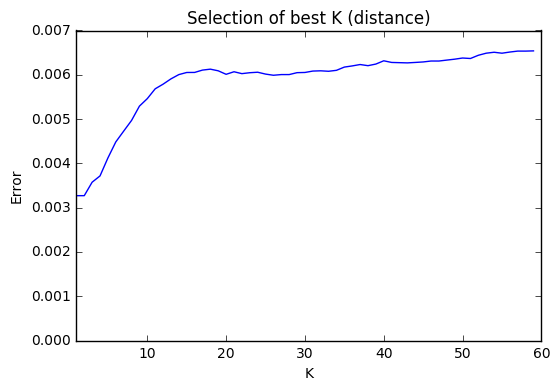

In [6]:
# Plot the result

plt.title('Selection of best K (distance)')
plt.ylabel('Error')
plt.xlabel('K')
plt.xlim(1, repetitions)
plt.plot(errors)
plt.show()

We choose K=2 to apply KNN to work accidents.

In [7]:
train_p = 0.6
K = 50
train, test = shuffle_accidents(train_p, accidents)
lat_and_lon_train = [list(x[:2]) for x in train]
lat_and_lon_test = [list(x[:2]) for x in test]
zone_train = [x[2] for x in train]

clf = neighbors.KNeighborsClassifier(K, weights='distance')
clf.fit(lat_and_lon_train, zone_train)
Z = clf.predict(lat_and_lon_test)

In [8]:
# Create a grid with the colors of the zones
x_min, x_max = min([x[0] for x in train]) - 0.01, max([x[0] for x in train]) + 0.01
y_min, y_max = min([x[1] for x in train]) - 0.01, max([x[1] for x in train]) + 0.01
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
cmap = ListedColormap(plt.cm.Paired(np.linspace(0, 1, len(np.unique(Z)))))
Z = Z.reshape(xx.shape)

In [9]:
# Convert data from bytes() to integer
W = [list(map(lambda x: int.from_bytes(x, byteorder='little'), array)) for array in Z]
train_transformed = list(map(lambda x: int.from_bytes(x, byteorder='little'), zone_train))

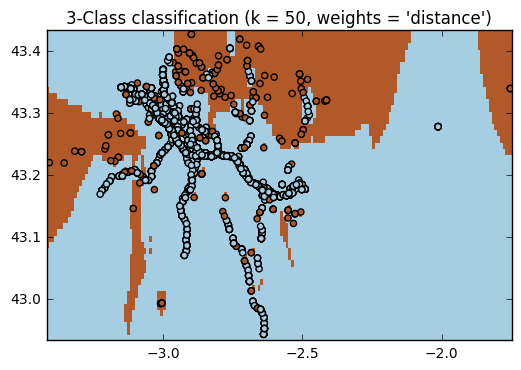

In [10]:
# Print the figure
plt.figure()
plt.pcolormesh(xx, yy, W, cmap=cmap)
plt.scatter([x[0] for x in train], [x[1] for x in train], c=train_transformed, cmap=cmap)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
              % (K, 'distance'))
plt.show()

In [11]:
# KNN with works from 2007
session2007 = get_db_session('sqlite:///../incidencesAux.db')
K = 2
works = session2007.query(Incidencia).filter(Incidencia.tipo == 'Obras').all()
accident_set = [x[:2] for x in accidents]
zones = [x[2] for x in accidents]
lat_and_lon_works = [(inc.longitud, inc.latitud) for inc in works]

In [12]:
clf = neighbors.KNeighborsClassifier(K, weights='distance')
clf.fit(accident_set, zones)
Z = clf.predict(lat_and_lon_works)

In [14]:
# Save Work with their respective zones
for index, w in enumerate(works):
    work = WorkZone()
    work.num_cluster = Z[index]
    work.autonomia = w.autonomia
    work.provincia = w.provincia
    work.fechahora_ini = w.fechahora_ini
    work.matricula = w.matricula
    work.carretera = w.carretera
    work.latitud = w.latitud
    work.longitud = w.longitud
    work.pk_final = w.pk_final
    work.pk_inicial = w.pk_inicial
    work.nivel = w.nivel
    work.sentido = w.sentido
    session2007.add(work)
session2007.commit()